# Assignment #3
Author: Austin Milne

## Problem Statement
Three 2D Anisotropic Magnetoresistor (AMR) sensors are used to measure the orientation of a permanent magnet. In an experiment, the magnet was rotated while its magnetic field direction was measured by three AMR sensors placed in close vicinity of each other.

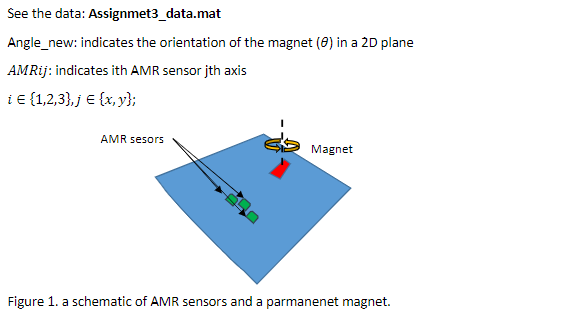

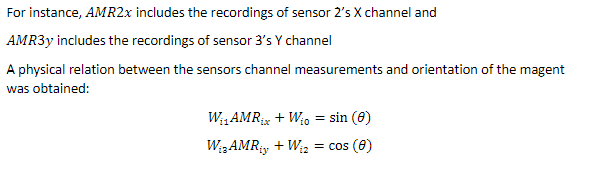

## Part 1
Using ordinary least squares and linear regression, find $W_S$ for each of the three sensors.  
- _Note that you need to find 4 weights for each sensor._  
- _Also note that $\theta$ is not a linear function of sensor reading, but its $\sin()$ and $\cos()$ are linear functions of sensor readings._

### Imports and Data Parsing

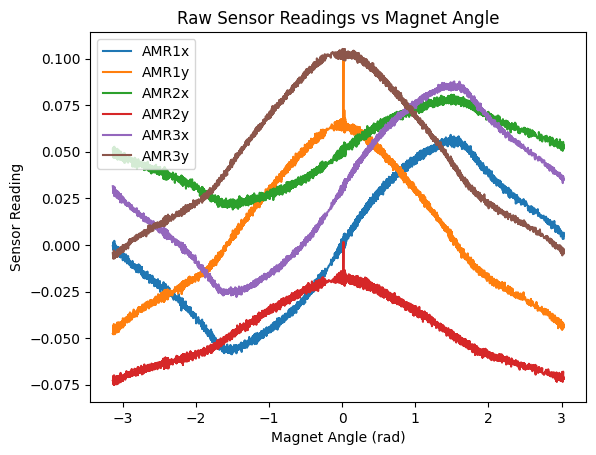

In [304]:
# Standard imports
import numpy as np
import pandas as pd
import scipy.io as sio
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tabulate import tabulate

# Read data from matlab .mat file
mat = sio.loadmat('Assignment3_data.mat')

# Filter out useful data
keys = [
    'Angle_new',
    'AMR1x',
    'AMR1y',
    'AMR2x',
    'AMR2y',
    'AMR3x',
    'AMR3y'
]
sensors = ["AMR1", "AMR2", "AMR3"]
mat = dict([(key, mat[key].flatten()) for key in mat.keys() if key in keys])

# Rewrite data into pandas dataframe
df = pd.DataFrame(mat)
df.sort_values(by='Angle_new', inplace=True)

# Plot dataframe by Angle_new
for axis in keys[1:]:
    plt.plot(df['Angle_new'], df[axis], label=axis)
plt.title("Raw Sensor Readings vs Magnet Angle")
plt.xlabel("Magnet Angle (rad)")
plt.ylabel("Sensor Reading")
plt.legend()
plt.show()

### Linear Regression

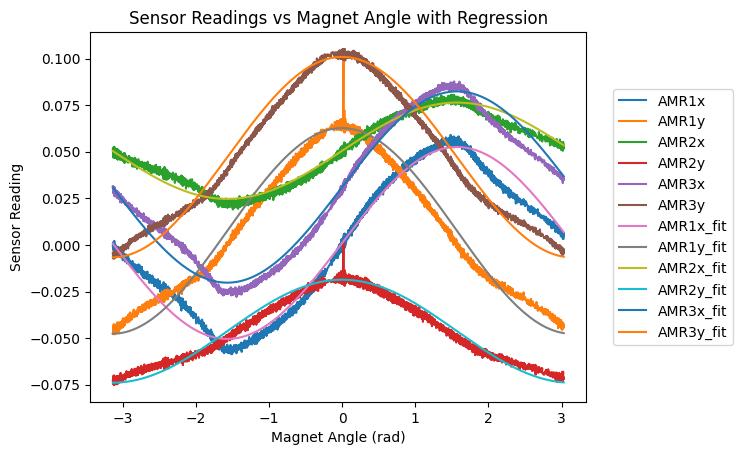

Regression Coefficients
+----------+---------+---------+---------+---------+---------+----------+
| Sensor   |     w_0 |     w_1 |   R^2_x |     w_2 |     w_3 |    R^2_y |
|----------+---------+---------+---------+---------+---------+----------|
| AMR1     | -0.0208 | 19.4271 |  0.9767 | -0.1365 | 18.1283 | 0.985877 |
| AMR2     | -1.9562 | 38.7100 |  0.9713 |  1.6744 | 36.1879 | 0.983693 |
| AMR3     | -0.6055 | 19.4923 |  0.9776 | -0.8763 | 18.6018 | 0.989171 |
+----------+---------+---------+---------+---------+---------+----------+


In [305]:
# Perform linear regression on each axis of each model
# x axis: us w_1 * r_ix + w_0 = sin(theta)
# y axis: us w_3 * r_iy + w_2 = cos(theta)
w = np.zeros((3, 4))
r_2 = np.zeros((3, 2))
for axis in keys[1:]:
    y = [np.sin(theta) for theta in df["Angle_new"]] if 'x' in axis else [np.cos(theta) for theta in df["Angle_new"]]
    x = sm.add_constant(df[axis])
    result = sm.OLS(y, x).fit()
    w[int(axis[-2])-1, 0 if 'x' in axis else 2] = result.params['const']
    w[int(axis[-2])-1, 1 if 'x' in axis else 3] = result.params[axis]
    r_2[int(axis[-2])-1, 0 if 'x' in axis else 1] = result.rsquared

# Graph the raw data and the regression lines
x_func = lambda w, theta: (np.sin(theta) - w[0]) / w[1]
y_func = lambda w, theta: (np.cos(theta) - w[2]) / w[3]
for axis in keys[1:]:
    plt.plot(df['Angle_new'], df[axis], label=axis)
for axis in keys[1:]:
    if 'x' in axis:
        plt.plot(df['Angle_new'], x_func(w[int(axis[-2])-1,:], df['Angle_new']), label=axis+"_fit")
    else: # 'y' in axis
        plt.plot(df['Angle_new'], y_func(w[int(axis[-2])-1,:], df['Angle_new']), label=axis+"_fit")
plt.title("Sensor Readings vs Magnet Angle with Regression")
plt.xlabel("Magnet Angle (rad)")
plt.ylabel("Sensor Reading")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show()

# Print table of regression coefficients and R^2 values
print("Regression Coefficients")
props = pd.DataFrame(w, columns=["w_0", "w_1", "w_2", "w_3"]) # Add regression coefficients
props["R^2_x"] = r_2[:, 0] # Add X R^2 values
props["R^2_y"] = r_2[:, 1] # Add Y R^2 values
props["Sensor"] = list(dict.fromkeys((key[0:-1] for key in keys[1:]))) # Add sensor names
props = props[["Sensor", "w_0", "w_1", "R^2_x", "w_2", "w_3", "R^2_y"]] # Reorder columns
print(tabulate(props, headers='keys', tablefmt='psql', showindex=False, floatfmt=(".4f", ".4f", ".4f", ".4f", ".4f", ".4f")))



## Part 2
Angle estimators can then be built based on each sensor model

$$
\hat{\theta}_i = \text{atan2}\left(\frac{W_{i,1}AMR_{i,x} + W_{i,0}}{W_{i,3}AMR_{i,y} + W_{i,2}}\right)
$$

2. Build estimation of magnet angles based on each sensor separately, $\hat{\theta}_1$, $\hat{\theta}_2$, and $\hat{\theta}_3$. Compute the error for each estimator:
    $$
    E_i = \theta - \hat{\theta}_i
    $$
    Compute each estimator's mean error and variance of error.

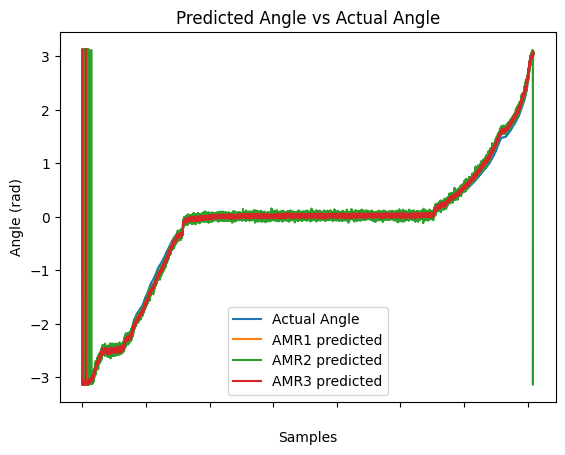

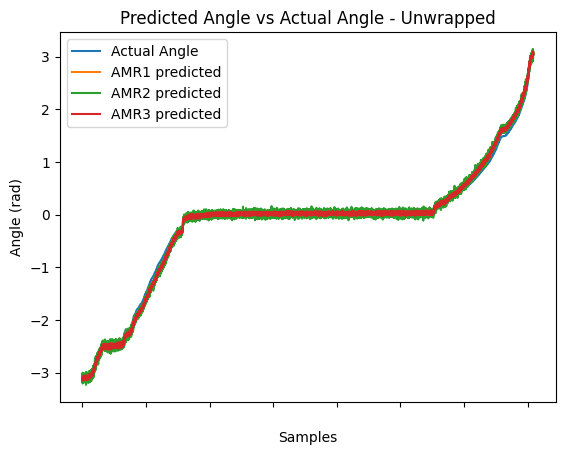

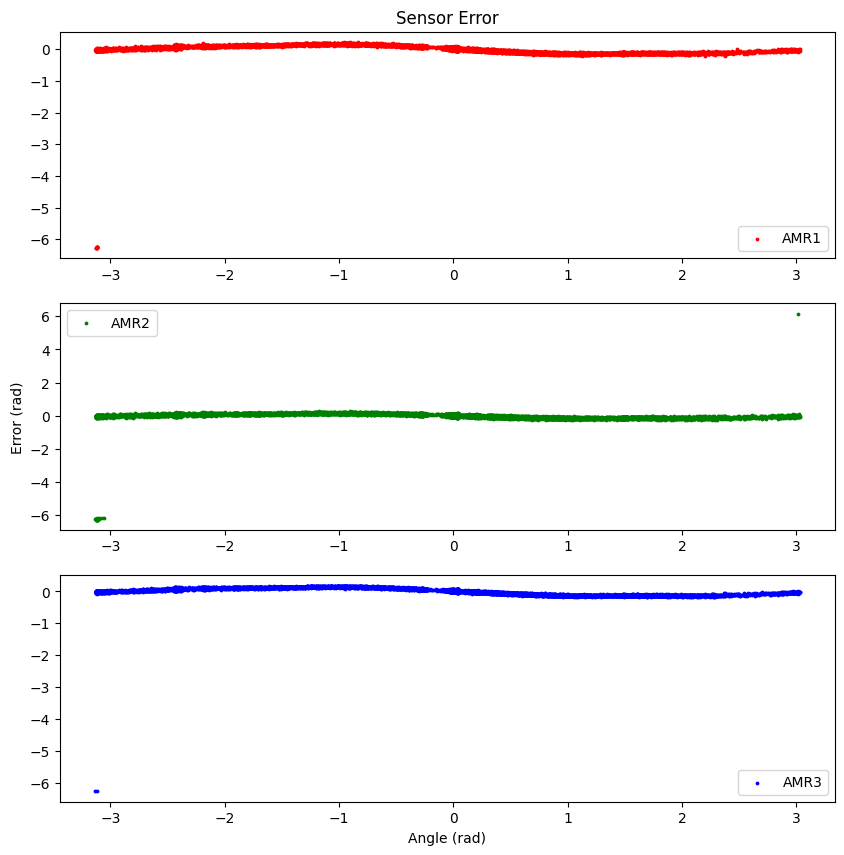

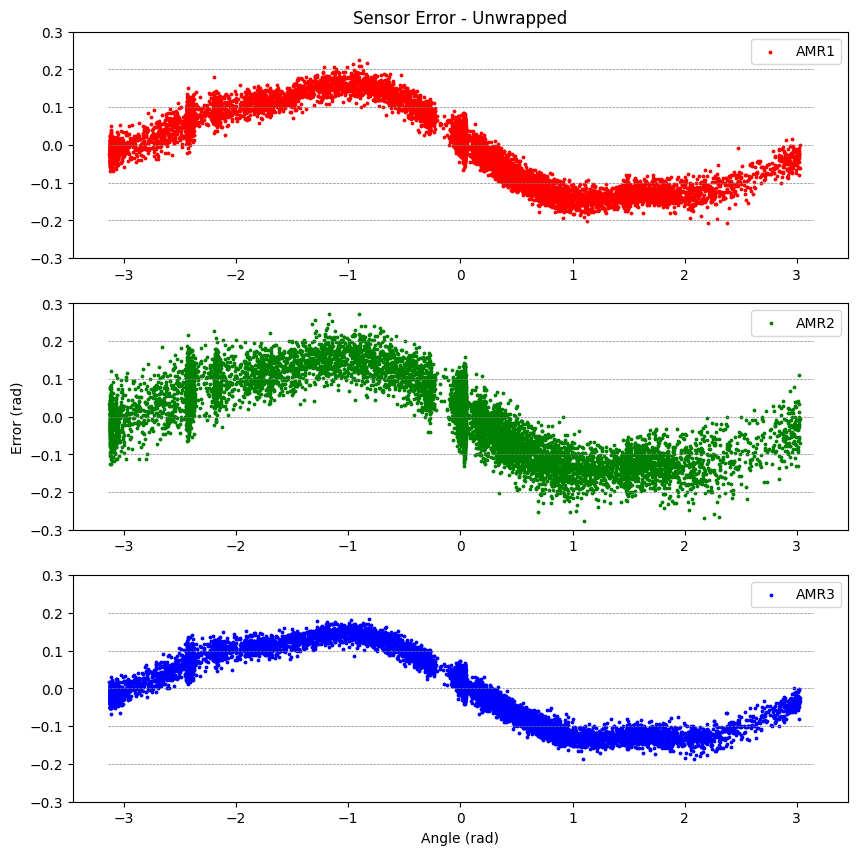

Sensor Properties with Error
+----------+------------+------------------+--------------+--------------------+
| Sensor   |   Mean Err |   Mean Err Unwrp |   Var of Err |   Var of Err Unwrp |
|----------+------------+------------------+--------------+--------------------|
| AMR1     |     0.0558 |           0.0520 |       0.0294 |             0.0051 |
| AMR2     |     0.0786 |           0.0598 |       0.1244 |             0.0061 |
| AMR3     |     0.0490 |           0.0483 |       0.0089 |             0.0044 |
+----------+------------+------------------+--------------+--------------------+


In [306]:
# Use the regression coefficients to predict the angle
# and determine the error of each sensor
theta = lambda w, x, y: np.arctan2(x * w[1] + w[0], y * w[3] + w[2])

# Calculate the predicted angle for each sensor
for sensor in sensors:
    df[sensor+'_pred'] = theta(w[int(sensor[-1])-1, :], df[sensor+'x'], df[sensor+'y'])

# Correct for radian wrap-around
for sensor in sensors:
    df[sensor+'_pred_unwrap'] = np.unwrap(df[sensor+'_pred'])
    if max(df[sensor+'_pred_unwrap']) > 2.1 * np.pi:
        df[sensor+'_pred_unwrap'] = df[sensor+'_pred_unwrap'] - 2 * np.pi

# Graph the predicted angle vs the actual angle
plt.plot(range(len(df['Angle_new'])), df['Angle_new'], label="Actual Angle")
for sensor in sensors:
    plt.plot(range(len(df[sensor+'_pred'])), df[sensor+'_pred'], label=sensor+" predicted")
plt.title("Predicted Angle vs Actual Angle")
plt.xticks(color='w')
plt.xlabel("Samples")
plt.ylabel("Angle (rad)")
plt.legend()
plt.show()

# Graph the predicted angle vs the actual angle (unwrapped)
plt.plot(range(len(df['Angle_new'])), df['Angle_new'], label="Actual Angle")
for sensor in sensors:
    plt.plot(range(len(df[sensor+'_pred_unwrap'])), df[sensor+'_pred_unwrap'], label=sensor+" predicted")
plt.title("Predicted Angle vs Actual Angle - Unwrapped")
plt.xticks(color='w')
plt.xlabel("Samples")
plt.ylabel("Angle (rad)")
plt.legend()
plt.show()

# Calculate error at each angle
for sensor in sensors:
    df[sensor+'_error'] = df['Angle_new'] - df[sensor+'_pred']
    df[sensor+'_error_unwrap'] = df['Angle_new'] - df[sensor+'_pred_unwrap']

# Graph the error of each sensor as a sub scatter plot
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i, sensor in enumerate(sensors):
    # axs[i].hlines(y=[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3], xmin=-np.pi, xmax=np.pi, colors='grey', linestyles='--', linewidth=0.5)
    axs[i].scatter(df['Angle_new'], df[sensor+'_error'], label=sensor, s=3, color=['r', 'g', 'b'][i])
    axs[i].set_title("Sensor Error") if i == 0 else axs[i].set_title("")
    if i == 2: axs[i].set_xlabel("Angle (rad)")
    if i == 1: axs[i].set_ylabel("Error (rad)")
    # axs[i].set_ylim(-0.3, 0.3)
    axs[i].legend()
plt.show()

# Graph the error of each sensor as a sub scatter plot (unwrapped)
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i, sensor in enumerate(sensors):
    axs[i].hlines(y=[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3], xmin=-np.pi, xmax=np.pi, colors='grey', linestyles='--', linewidth=0.5)
    axs[i].scatter(df['Angle_new'], df[sensor+'_error_unwrap'], label=sensor, s=3, color=['r', 'g', 'b'][i])
    axs[i].set_title("Sensor Error - Unwrapped") if i == 0 else axs[i].set_title("")
    if i == 2: axs[i].set_xlabel("Angle (rad)")
    if i == 1: axs[i].set_ylabel("Error (rad)")
    axs[i].set_ylim(-0.3, 0.3)
    axs[i].legend()
plt.show()
    
# Determine the mean error and variance of error for each sensor
props["Mean Err"] = [np.mean(np.abs(df[sensor+'_error'])) for sensor in sensors]
props["Mean Err Unwrp"] = [np.mean(np.abs(df[sensor+'_error_unwrap'])) for sensor in sensors]
props["Var of Err"] = [np.var(df[sensor+'_error']) for sensor in sensors]
props["Var of Err Unwrp"] = [np.var(df[sensor+'_error_unwrap']) for sensor in sensors]
print("Sensor Properties with Error")
display = props[["Sensor", "Mean Err", "Mean Err Unwrp", "Var of Err", "Var of Err Unwrp"]]
print(tabulate(display, headers='keys', tablefmt='psql', showindex=False, floatfmt=(".4f", ".4f", ".4f", ".4f", ".4f")))

### ⚠️ IMPORTANT NOTE ⚠️
Due to the boundary conditions of the angle measurements wrapping around at $\pm \pi$, there are cases where the predicted angle measurement wraps around the boundary. For example, if the true angle is $\pi * 0.999$ and the predicted angle is $pi * 1.001$, it will report as $\pi*-0.999$, resulting in an error of almost $2\pi$. To avoid this, each measurement is inspected to prevent it from wrapping the boundary. This is done by checking if the difference between the true and predicted angle is greater than $\pi$ (as it should never have that high of a prediction error) and if so, adding $2\pi$ to bring it to the correct error distance from the true angle.

_**This seems to be an error with the calculation done for the Quiz answers, as they are not entirely accurate!!!**_


## Part 3
Now fuse the three estimators using weighted sum fusion (See Week 3, Lecture 8, 
recorded session 9) based on inverse of their error variance.

Sensor fusion equation:
$$
{\hat{y}}_{ws} = \frac{ \frac{y_1}{{\sigma_1}^2} + \frac{y_2}{{\sigma_2}^2} + \cdots + \frac{y_n}{{\sigma_n}^2} }{ \frac{1}{{\sigma_1}^2} + \frac{1}{{\sigma_2}^2} + \cdots + \frac{1}{{\sigma_n}^2} }
\\~\\
\text{Where: } \sigma_i^2 = \text{var}(\text{Error}_i)
$$

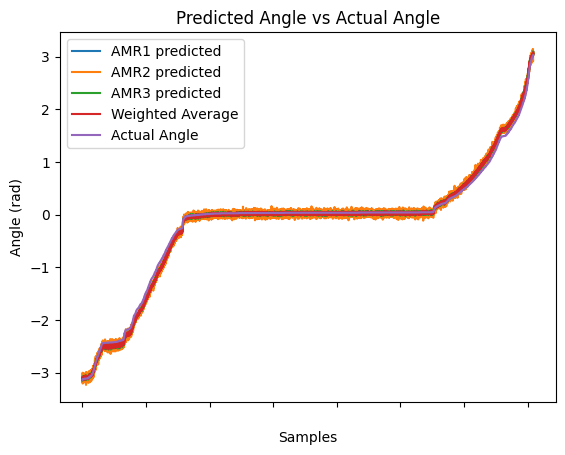

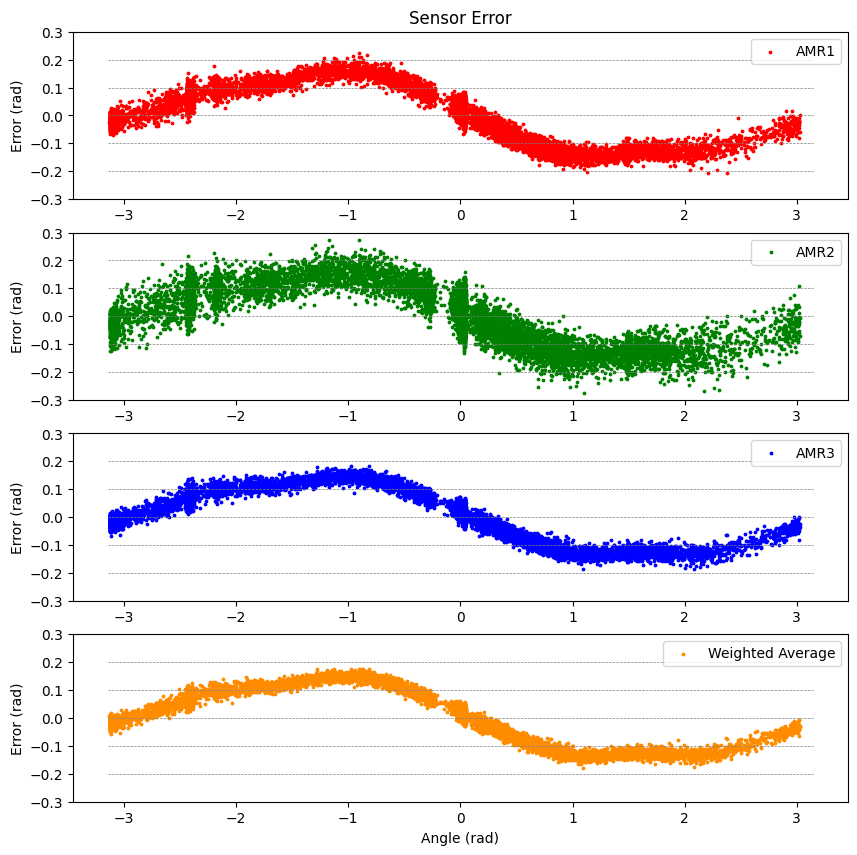

Sensor Properties with Error
+--------------+------------------+--------------------+
| Sensor       |   Mean Err Unwrp |   Var of Err Unwrp |
|--------------+------------------+--------------------|
| AMR1         |           0.0520 |             0.0051 |
| AMR2         |           0.0598 |             0.0061 |
| AMR3         |           0.0483 |             0.0044 |
| Weighted Sum |           0.0067 |             0.0045 |
+--------------+------------------+--------------------+


In [307]:
# Create weighted average of sensor predictions
df['Angle_pred'] = (df['AMR1_pred_unwrap'] / props["Var of Err"][0] + df['AMR2_pred_unwrap'] / props["Var of Err"][1] + df['AMR3_pred_unwrap'] / props["Var of Err"][2]) / (1/props["Var of Err"][0] + 1/props["Var of Err"][1] + 1/props["Var of Err"][2])

# Plot each sensors prediction and the weighted average
for sensor in sensors:
    plt.plot(range(len(df[sensor+'_pred_unwrap'])), df[sensor+'_pred_unwrap'], label=sensor+" predicted")
plt.plot(range(len(df['Angle_pred'])), df['Angle_pred'], label="Weighted Average")
plt.plot(range(len(df['Angle_new'])), df['Angle_new'], label="Actual Angle")
plt.title("Predicted Angle vs Actual Angle")
plt.xticks(color='w')
plt.xlabel("Samples")
plt.ylabel("Angle (rad)")
plt.legend()
plt.show()

# Calculate the error of the weighted average
df['Angle_error'] = df['Angle_new'] - df['Angle_pred']

# Graph the error of the weighted average and the error of each sensor
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for i, sensor in enumerate(sensors):
    axs[i].hlines(y=[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3], xmin=-np.pi, xmax=np.pi, colors='grey', linestyles='--', linewidth=0.5)
    axs[i].scatter(df['Angle_new'], df[sensor+'_error'], label=sensor, s=3, color=['r', 'g', 'b'][i])
    axs[i].set_title("Sensor Error") if i == 0 else axs[i].set_title("")
    axs[i].set_ylabel("Error (rad)")
    axs[i].set_ylim(-0.3, 0.3)
    axs[i].legend()
axs[3].hlines(y=[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3], xmin=-np.pi, xmax=np.pi, colors='grey', linestyles='--', linewidth=0.5)
axs[3].scatter(df['Angle_new'], df['Angle_error'], label="Weighted Average", s=3, color='darkorange')
axs[3].set_ylabel("Error (rad)")
axs[3].set_ylim(-0.3, 0.3)
axs[3].set_xlabel("Angle (rad)")
axs[3].legend()
plt.show()

# Determine the mean error and variance of error for the weighted average
ws = pd.DataFrame({
    "Sensor": "Weighted Sum",
    "Mean Err Unwrp": np.mean(df['Angle_error']),
    "Var of Err Unwrp": np.var(df['Angle_error'])
}, index=[0])
props_ext = pd.concat([props, ws], ignore_index=True)
display = props_ext[["Sensor", "Mean Err Unwrp", "Var of Err Unwrp"]]
print("Sensor Properties with Error")
print(tabulate(display, headers='keys', tablefmt='psql', showindex=False, floatfmt=(".4f", ".4f", ".4f", ".4f", ".4f")))